In [27]:
import torch 
import time 

print(torch.__version__)

dtype=torch.half
warm_up = 100 
n_iter = 1000

fs = [] 
bs = []

for n in (1, 32, 64): 
    for c in (1, 32, 64): 
        for h in (14, 28, 56, 128, 256): 
            w = h
            for ks in (2, 3, 5, 7): 
                torch.cuda.empty_cache() 

                print(f'n {n}, c {c}, h {h}, w {w}, ks {ks}', end='\t')

                a = torch.randn(n, c, h, w, dtype=dtype, device='cuda').contiguous(memory_format=torch.channels_last)
                ref_a = a.clone().contiguous() 

                a.requires_grad_() 
                ref_a.requires_grad_() 

                pool = torch.nn.AvgPool2d(ks).cuda()
                ref_pool = torch.nn.AvgPool2d(ks).cuda()

                out = pool(a)
                ref_out = ref_pool(ref_a)

                grad = torch.ones_like(out)
                out.backward(grad, retain_graph=True)
                ref_out.backward(grad, retain_graph=True)

                assert((out==ref_out).all().item())
                assert((a.grad==ref_a.grad).all().item())

                ########## warm up ##########
                for _ in range(warm_up): 
                    out = pool(a)
                    ref_out = ref_pool(ref_a)
                    out.backward(grad, retain_graph=True)
                    ref_out.backward(grad, retain_graph=True)

                ########## channels_last forward ##########
                torch.cuda.synchronize() 
                ts = time.time() 

                for _ in range(n_iter): 
                    out = pool(a)
                    torch.cuda.synchronize() 

                t_channels_last_forward = (time.time() - ts) / n_iter

                ########## contiguous forward ##########
                torch.cuda.synchronize()
                ts = time.time() 

                for _ in range(n_iter): 
                    ref_out = ref_pool(a)
                    torch.cuda.synchronize() 

                t_contiguous_forward = (time.time() - ts) / n_iter

                ########## channels_last backward ##########
                torch.cuda.synchronize() 
                ts = time.time() 

                for _ in range(n_iter): 
                    out.backward(grad, retain_graph=True)
                    torch.cuda.synchronize() 

                t_channels_last_backward = (time.time() - ts) / n_iter

                ########## contiguous backward ##########
                torch.cuda.synchronize()
                ts = time.time() 

                for _ in range(n_iter): 
                    ref_out.backward(grad, retain_graph=True)
                    torch.cuda.synchronize() 

                t_contiguous_backward = (time.time() - ts) / n_iter
                
                ########## stat ##########
                forward_speedup = t_contiguous_forward/t_channels_last_forward
                backward_speedup = t_contiguous_backward/t_channels_last_backward
                fs.append(forward_speedup)
                bs.append(backward_speedup)
                
                ########## print ##########
                print('channels_last speedup, forward {:.3f}, backward {:.3f}'.format(
                    forward_speedup, backward_speedup
                ))
                

1.6.0a0+0a8fd79
n 1, c 1, h 14, w 14, ks 2	channels_last speedup, forward 0.911, backward 1.069
n 1, c 1, h 14, w 14, ks 3	channels_last speedup, forward 0.859, backward 1.046
n 1, c 1, h 14, w 14, ks 5	channels_last speedup, forward 0.856, backward 1.054
n 1, c 1, h 14, w 14, ks 7	channels_last speedup, forward 0.780, backward 0.997
n 1, c 1, h 28, w 28, ks 2	channels_last speedup, forward 0.993, backward 1.052
n 1, c 1, h 28, w 28, ks 3	channels_last speedup, forward 0.853, backward 1.056
n 1, c 1, h 28, w 28, ks 5	channels_last speedup, forward 0.851, backward 1.050
n 1, c 1, h 28, w 28, ks 7	channels_last speedup, forward 0.859, backward 1.050
n 1, c 1, h 56, w 56, ks 2	channels_last speedup, forward 0.857, backward 1.053
n 1, c 1, h 56, w 56, ks 3	channels_last speedup, forward 0.866, backward 1.048
n 1, c 1, h 56, w 56, ks 5	channels_last speedup, forward 0.869, backward 1.048
n 1, c 1, h 56, w 56, ks 7	channels_last speedup, forward 0.846, backward 1.040
n 1, c 1, h 128, w 128, 

n 32, c 64, h 14, w 14, ks 2	channels_last speedup, forward 0.946, backward 1.002
n 32, c 64, h 14, w 14, ks 3	channels_last speedup, forward 0.957, backward 0.983
n 32, c 64, h 14, w 14, ks 5	channels_last speedup, forward 0.911, backward 0.983
n 32, c 64, h 14, w 14, ks 7	channels_last speedup, forward 0.992, backward 1.040
n 32, c 64, h 28, w 28, ks 2	channels_last speedup, forward 0.908, backward 1.012
n 32, c 64, h 28, w 28, ks 3	channels_last speedup, forward 0.907, backward 1.015
n 32, c 64, h 28, w 28, ks 5	channels_last speedup, forward 0.894, backward 1.023
n 32, c 64, h 28, w 28, ks 7	channels_last speedup, forward 0.849, backward 1.016
n 32, c 64, h 56, w 56, ks 2	channels_last speedup, forward 0.992, backward 0.955
n 32, c 64, h 56, w 56, ks 3	channels_last speedup, forward 0.997, backward 1.002
n 32, c 64, h 56, w 56, ks 5	channels_last speedup, forward 0.997, backward 1.000
n 32, c 64, h 56, w 56, ks 7	channels_last speedup, forward 1.000, backward 1.000
n 32, c 64, h 12

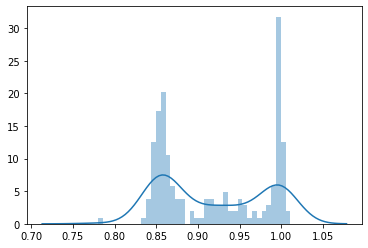

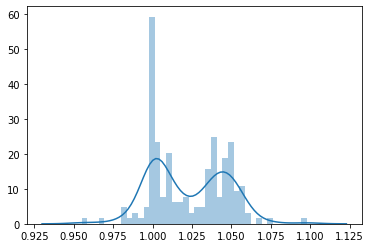

In [28]:
import seaborn as sns 
import matplotlib.pyplot as plt 

sns.distplot(fs, bins=40)
plt.show() 

sns.distplot(bs, bins=40)
plt.show()